In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

# Tensorflow import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed

2024-04-28 14:27:21.782261: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 14:27:22.510726: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 14:27:22.517009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 14:27:23.977159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

def testAccuracy(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    predicted_categories = tf.argmax(y_pred, axis=1)
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')

def plot_image(pred_array, true_label, img, class_names):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                ),
                                color=color)

def predictions(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    # Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
    indices = random.sample(range(len(images)), 15)
    # Color correct predictions in blue and incorrect predictions in red.
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(4*num_cols, 2*num_rows))
    for i,index in enumerate(indices):
      plt.subplot(num_rows, num_cols, i+1)
      plot_image(y_pred[index], true_categories[index], images[index],class_names)
    plt.tight_layout()
    plt.show()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("final_model.h5", save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=5, restore_best_weights=True
)

In [3]:
set_seed(111) # set random seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

In [4]:
class_dirs = os.listdir("vegetables_images/train") # list all directories inside "train" folder

image_dict = {} # dict to store image array(key) for every class(value)

count_dict = {} # dict to store count of files(key) for every class(value)

# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'vegetables_images/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

**Exploratory Data Analysis**

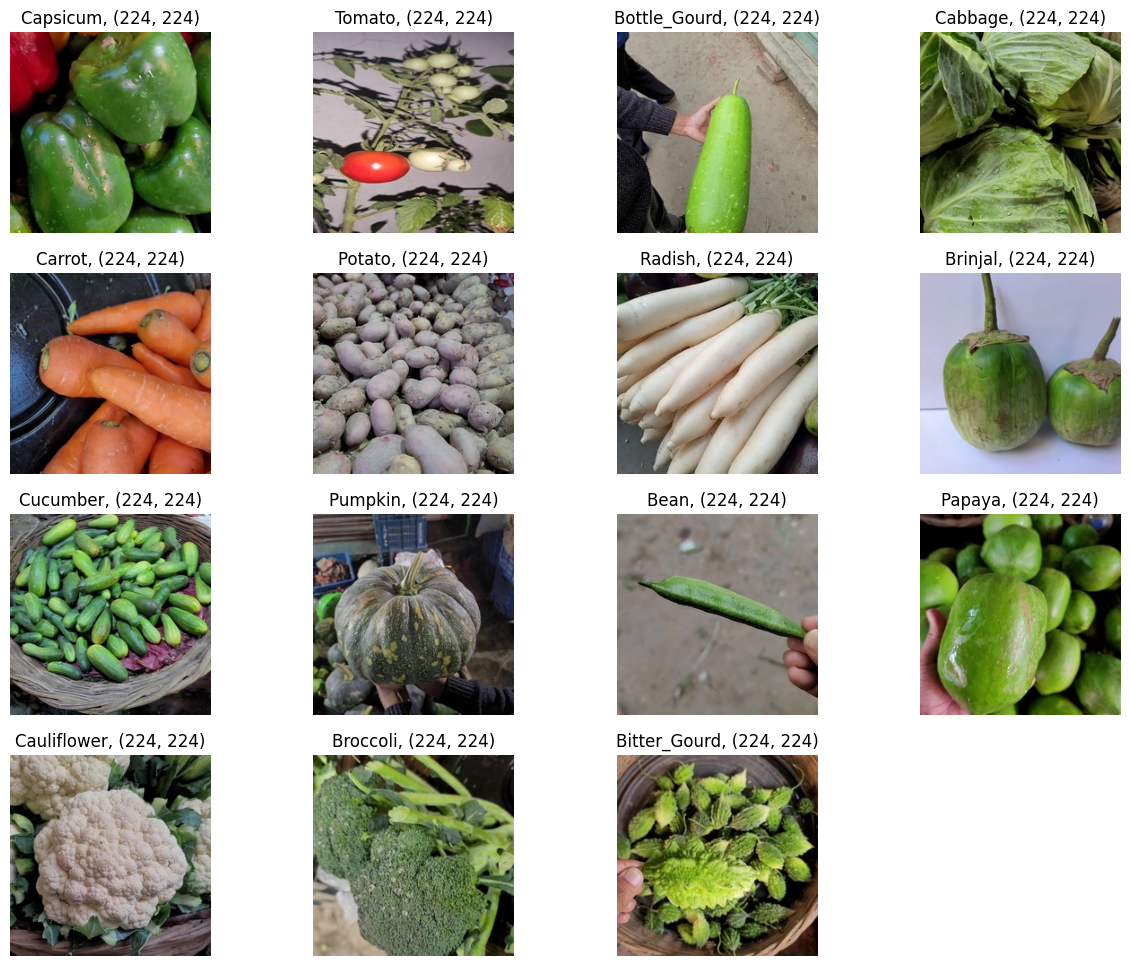

In [19]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()):
    # create a subplot axis
    ax = plt.subplot(4, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

In [20]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

Count of training samples per class:
            class  count
0       Capsicum   1000
1         Tomato   1000
2   Bottle_Gourd   1000
3        Cabbage   1000
4         Carrot   1000
5         Potato   1000
6         Radish   1000
7        Brinjal   1000
8       Cucumber   1000
9        Pumpkin   1000
10          Bean   1000
11        Papaya   1000
12   Cauliflower   1000
13      Broccoli   1000
14  Bitter_Gourd   1000


<Figure size 1500x1200 with 0 Axes>

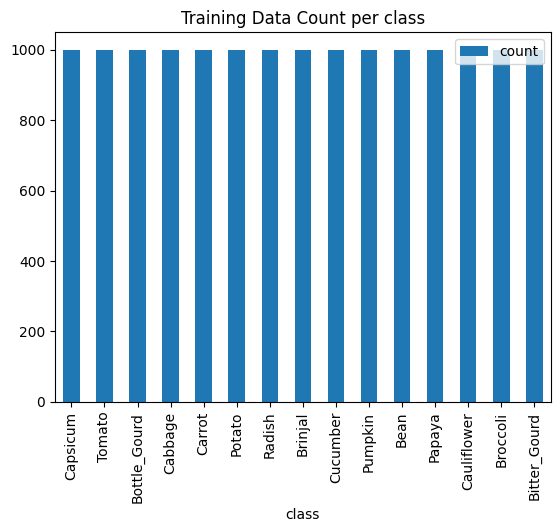

In [21]:
# draw a bar plot using pandas in-built plotting function
plt.figure(figsize=(15,12))
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class")
plt.show()

**LOADING DATASET**

In [8]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    "vegetables_images/train", shuffle = True,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    "vegetables_images/validation", shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    "vegetables_images/test", shuffle = False,
)


Loading Train Data...
Found 15000 files belonging to 15 classes.

Loading Validation Data...
Found 3000 files belonging to 15 classes.

Loading Test Data...
Found 3000 files belonging to 15 classes.


**Data Preprocessing**

In [9]:
height, width = 224, 224

# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

In [10]:
num_classes = 15
hidden_size_1 = 1024
hidden_size_2 = 256

**Transfer Learning**

**MobileNet**

In [11]:
pretrained_mobilenet_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_mobilenet_model.trainable=False
mobilenet_model = tf.keras.Sequential([
    pretrained_mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(15, activation='softmax')
])

In [12]:
mobilenet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 2277199 (8.69 MB)
Trainable params: 19215 (75.06 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [14]:
history_mobilenet = mobilenet_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/10


2024-04-28 14:28:34.289588: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2024-04-28 14:28:34.425596: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156905472 exceeds 10% of free system memory.


  1/469 [..............................] - ETA: 22:12 - loss: 3.2200 - accuracy: 0.0938

2024-04-28 14:28:34.941207: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2024-04-28 14:28:34.981736: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156905472 exceeds 10% of free system memory.


  2/469 [..............................] - ETA: 4:27 - loss: 2.9657 - accuracy: 0.1094 

2024-04-28 14:28:35.521590: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.


469/469 [==============================] - 187s 394ms/step - loss: 0.1991 - accuracy: 0.9585 - val_loss: 0.0366 - val_accuracy: 0.9957
Epoch 2/10
469/469 [==============================] - 185s 393ms/step - loss: 0.0242 - accuracy: 0.9966 - val_loss: 0.0197 - val_accuracy: 0.9960
Epoch 3/10
469/469 [==============================] - 182s 389ms/step - loss: 0.0123 - accuracy: 0.9991 - val_loss: 0.0138 - val_accuracy: 0.9970
Epoch 4/10
469/469 [==============================] - 180s 383ms/step - loss: 0.0072 - accuracy: 0.9997 - val_loss: 0.0107 - val_accuracy: 0.9980
Epoch 5/10
469/469 [==============================] - 188s 401ms/step - loss: 0.0046 - accuracy: 0.9999 - val_loss: 0.0089 - val_accuracy: 0.9977
Epoch 6/10
469/469 [==============================] - 184s 393ms/step - loss: 0.0032 - accuracy: 0.9999 - val_loss: 0.0078 - val_accuracy: 0.9980
Epoch 7/10
469/469 [==============================] - 185s 394ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.0072 - val_accura

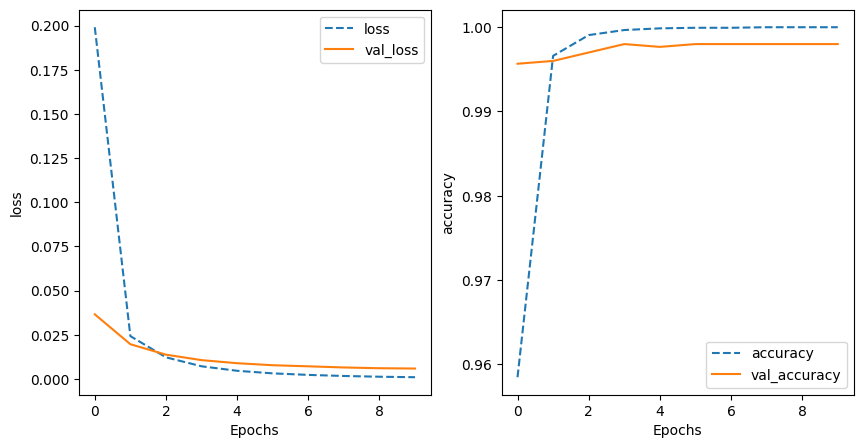

In [15]:
training_plot(['loss', 'accuracy'], history_mobilenet)

In [17]:
if not os.path.exists('model'):
    os.makedirs('model')

mobilenet_model.save('model/mobilenet_model')

INFO:tensorflow:Assets written to: model/mobilenet_model/assets


INFO:tensorflow:Assets written to: model/mobilenet_model/assets


In [18]:
testAccuracy(mobilenet_model)

94/94 [==============================] - 32s 322ms/step

Test Accuracy: 99.87%

